In [62]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import autograd.numpy as np
from autograd import hessian 


In [61]:
#pip install autograd


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Define the grid size
x_size =25  # grid width
y_size = 25 # grid height
sample_size = y_size * x_size 
 
# Define the mean and standard deviation for the normal distribution
mean = 0
std_dev = 1

# Generate a grid of normally distributed random values
np.random.seed(30) 
normal_grid_residual = np.random.normal(loc=mean, scale=std_dev, size=(y_size, x_size))


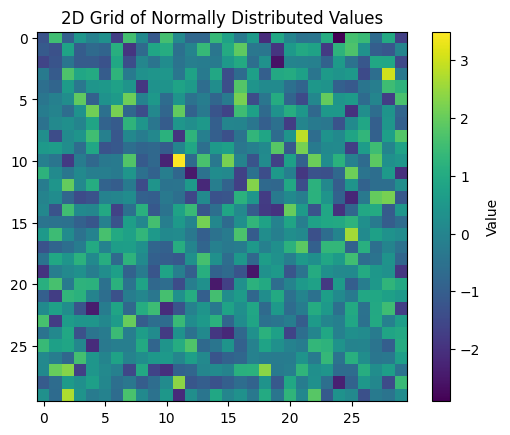

In [3]:
# Visualize the result of normal_grid_residual
plt.imshow(normal_grid_residual, cmap='viridis')
plt.colorbar(label='Value')
plt.title("2D Grid of Normally Distributed Values")
plt.show()

In [23]:
# Initialize X and Y with zeros including padding 
X = np.zeros((y_size + 2, x_size + 2))
Y= np.zeros_like(X) 

# Fixed i.i.d. noise e_ij ~ N(0, 1)
e = np.random.normal(loc=mean, scale=std_dev, size=(y_size + 2, x_size + 2))

In [72]:
# example of 'for' loop 
for i in range(5):
    print(i, end=", ") 



0, 1, 2, 3, 4, 

In [9]:
X =[1,2,3,4,5]
X[1:-1]

[2, 3, 4]

In [24]:
# Iterate the process 20 times

for t in range (30): 
    X_prev = X.copy() 
    X_lag = np.zeros_like(X) 

    for i  in range (1, y_size +1):
        for j in range (1, x_size +1):
            u = np.sqrt((i/y_size) ** 2 + (j/x_size) ** 2)  
            X_lag[i, j] = (X_prev[i-1, j] + X_prev[i+1, j] + X_prev[i, j-1] + X_prev[i, j+1])/4
            X[i, j] = 0.8 * np.sin(np.sqrt(2) * np.pi * u) * X_lag[i, j] + e[i, j] 


In [25]:
# Final values after 20 iterations
X_final = X[1:-1, 1:-1]  # remove padding
Y_final = X_final.copy()  # for now, Y = X
Y_lag = X_lag[1:-1, 1:-1] 
np.min(Y_final)

np.float64(-3.8054078396861453)

In [29]:
np.min(Y_lag) 

np.float64(-2.5219930309138494)

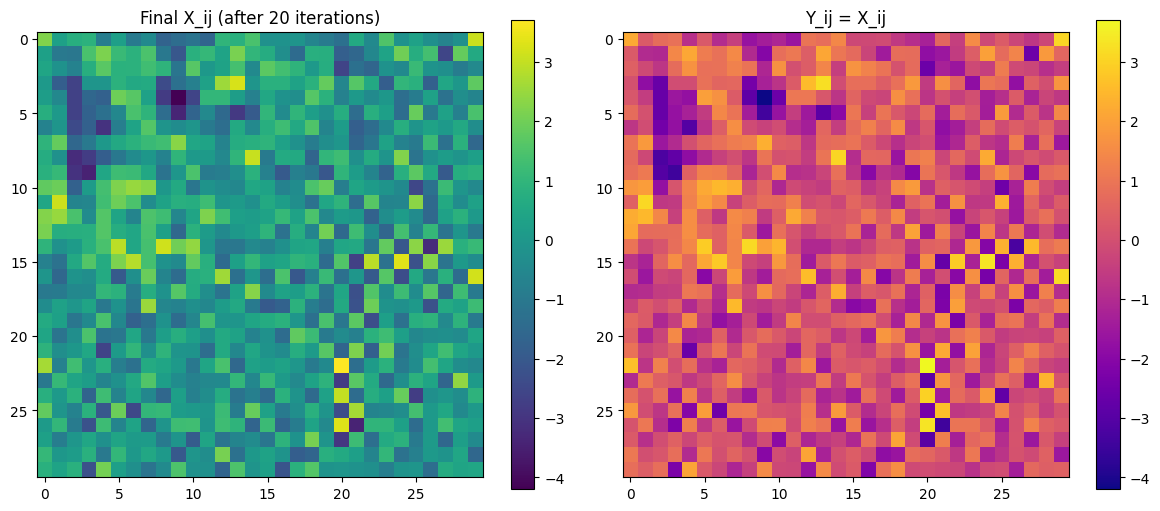

In [30]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im0 = ax[0].imshow(X_final, cmap='viridis')
ax[0].set_title("Final X_ij (after 20 iterations)")
plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(Y_final, cmap='plasma')
ax[1].set_title("Y_ij = X_ij")
plt.colorbar(im1, ax=ax[1])
plt.tight_layout() 
plt.show()

In [16]:
# # kernel function
# def e_kernel(u):
#     return 0.75 * (1 - u**2) * (np.abs(u) <= 1) 



# def U(t1,t2):
#     dis_u = np.sqrt((i/y_size - t1) ** 2 + (j/x_size - t2) ** 2)
#     return dis_u

# h = 0.5 
# t1 =0.1 
# t2 =0.2


# Y_new = np.zeros((y_size, x_size))
# X1_new = np.zeros_like(Y_new) 
# X2_new = np.zeros_like(Y_new)

# for i in range(0, y_size):
#     for j in range(0, x_size): 
#         Y_new[i,j]= np.sqrt(1/h * e_kernel(U(t1,t2)/h)) * Y_final[i,j] 
#         X1_new[i,j] = np.sqrt(1/h * e_kernel(U(t1,t2)/h)) * Y_lag[i,j]
#         X2_new[i,j] = np.sqrt(1/h * e_kernel(U(t1,t2)/h)) * Y_lag[i,j]  * (U(t1,t2)) 


In [26]:
# kernel function
def e_kernel(u, v):
    r2 = (u**2 + v**2) 
    return (0.75/np.pi) * (1 - r2) * (r2 <= 1) 

In [7]:
e_kernel(0.5,0)

0.17904931097838225

In [27]:
def table_local_cv(a, b, h): 
    
    Y_new = np.zeros((y_size, x_size))
    X1_new = np.zeros_like(Y_new) 
    X2_new = np.zeros_like(Y_new) 
    X3_new = X2_new
    for i in range(0, y_size):
        for j in range(0, x_size): 
            u,v = (a - i)/y_size, (b - j)/x_size 
            kernal_weight = np.sqrt((1/h**2) * e_kernel(u/h, v/h))
            Y_new[i,j]= kernal_weight * Y_final[i,j] 
            X1_new[i,j] = kernal_weight * Y_lag[i,j] 
            # X2_new[i,j] = kernal_weight * Y_lag[i,j] * ((a - i)/y_size) 
            # X3_new[i,j] = kernal_weight * Y_lag[i,j] * ((b - j)/x_size)
            
    flat_index = a * Y_final.shape[1] + b 
    
    Y_new_cv = np.delete(Y_new, flat_index)
    X1_new_cv = np.delete(X1_new, flat_index) 
    # X2_new_cv = np.delete(X2_new, flat_index) 
    # X3_new_cv = np.delete(X3_new, flat_index) 

    return pd.DataFrame({
        'Y_new_cv': Y_new_cv,
        'X1_new_cv': X1_new_cv,
        # 'X2_new_cv': X2_new_cv,
        # 'X3_new_cv': X3_new_cv
        })


In [28]:
def cross_validation(h):

    Y_pred_loo = np.zeros((y_size, x_size))
    epsilon = []
    for a in range(0, y_size):
        for b in range(0, x_size): 
            
            df_local = table_local_cv(a, b, h) 
            Y = df_local['Y_new_cv'].to_numpy()
            X = df_local[['X1_new_cv']].to_numpy() 
            beta_hat, *_ = np.linalg.lstsq(X, Y) 


            # Left-out test point
            x_test = np.array([Y_lag[a,b]])  # shape (1,1)


            # LOOCV prediction:  Ŷ^(i) = Xi * β^(-i) 
            # @ dot product
            Y_pred_ = x_test @ beta_hat 

            epsilon_hat =  (np.array([Y_final[a,b]]) -  Y_pred_ ) 
            error_squared = epsilon_hat @ epsilon_hat

            epsilon.append(error_squared.item())

            
    cv_sore = np.sum(epsilon)/sample_size
    return cv_sore

# make beta_hat be 2 dimension, so Y_final[a,b],X_lag[i, j] can be used   

In [29]:
cross_validation(1) 

np.float64(1.2411160473062395)

In [30]:
sample_size = y_size * x_size 
cv_h_value = np.zeros(sample_size) 
for i in range(sample_size):  
    cv_h_value[i] = cross_validation( (i + 1) / sample_size) 

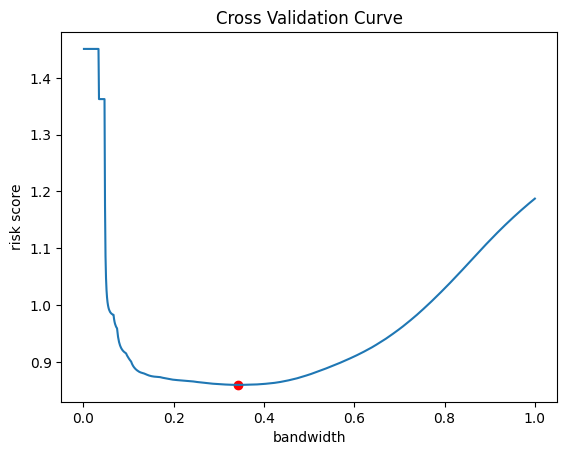

In [19]:

bandwidth = np.linspace(1/sample_size, 1, sample_size)
# Find minimum
min_index = np.argmin(cv_h_value)
min_bandwidth = bandwidth[min_index]
min_cv = cv_h_value[min_index]

# Plot CV curve
plt.plot(bandwidth, cv_h_value)

# Mark the minimum point in red
plt.scatter(min_bandwidth, min_cv, color='red') 

plt.xlabel("bandwidth")
plt.ylabel("risk score")
plt.title("Cross Validation Curve") 
plt.show()

In [39]:
# find the minimum cv value and its h
idx_min = np.argmin(cv_h_value)     # index of minimum
h_min = bandwidth[idx_min]                  # corresponding h
cv_min = cv_h_value[idx_min]        # minimum value

print("Minimum cv_h_value:", cv_min)
print("Corresponding h:", h_min)

Minimum cv_h_value: 0.9069773765112994
Corresponding h: 0.24666666666666667


In [46]:
# print(type(Y_new))
# print(Y_new.ndim) 
# print(Y_new.shape) 

np.array([3]) @ np.array([4])

np.int64(12)

array([-0.00771753])

In [85]:
a = np.delete(Y_final, [1,1])
Y_final.shape
a.shape

(199,)

In [23]:
# X3 = np.arange(20)
# print(X3)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [61]:
# # LOOCV Procedure
# # Example list
# X = [10, 20, 30, 40, 50]
# Y = [20, 35, 65, 83, 97] 
# n = len(X) 

# Y_pred_loo = []
# for i in range(n): 


#     # Leave out the i-th element 
#     looX = np.array([X[j] for j in range(n) if j != i]).reshape(-1, 1) 
#     looY = np.array([Y[j] for j in range(n) if j != i]).reshape(-1, 1) 
   
#     beta_hat = np.linalg.inv(looX.T @ looX) @ looX.T @ looY

#     # Left-out test point
#     x_test = np.array([[X[i]]])  # shape (1,1)
    
#     # LOOCV prediction: Ŷ^(i) = Xi * β^(i)
#     y_pred_i = x_test @ beta_hat
#     Y_pred_loo.append(y_pred_i.item())  # convert from 1x1 array to scalar

# print(Y_pred_loo) 

[20.037037037037035, 40.470588235294116, 59.15217391304348, 78.97435897435898, 102.83333333333333]


In [89]:
Y = df_local[['Y_new']].to_numpy()
Y.shape

(200, 1)

In [23]:
# # 'command + /'
# arr = np.array([[1, 2, 3],
#                 [4, 5, 6],
#                 [7, 8, 9]]) 
# i, j = 1,0 
# flat_index = i * arr.shape[1] + j
# arr_new = np.delete(arr, flat_index)
# # arr.reshape(-1).shape
# arr_new  
# arr.reshape(-1)   
# np.zeros(0)

array([1, 2, 3, 5, 6, 7, 8, 9])

In [50]:
i, j = 9, 4   # any grid index

u = np.array([(i+1)/20, (j+1)/20])
r = np.linalg.norm(u)
value_a = a(u) 
value_grad = grad_a(u)

r


np.float64(0.7071067811865476)

In [47]:
# -------------------------------------------------------------
# 1. Define model: a(u) = 0.8 sin( sqrt(2)*pi * ||u|| ) 
# -------------------------------------------------------------

def a(u): 
    r = np.linalg.norm(u)  # computes the Euclidean length||u|| 
    return 0.8*np.sin(np.sqrt(2)*np.pi*r)  

def grad_a(u):
    r = np.linalg.norm(u) 
    k = np.sqrt(2)*np.pi
    if r == 0:
        return np.array([0.0, 0.0])  # gradient = 0 at the center
    return 0.8 * k * np.cos(k*r) * u / r

H = hessian((np.array([0.4, 0.3]))


In [74]:
A = np.array([
    [a(np.array([(i+1)/20, (j+1)/20])) for j in range(20)]
    for i in range(20)
]) 

grad =   np.array([
    [grad_a(np.array([(i+1)/20, (j+1)/20])) for j in range(20)]
    for i in range(20)
])

H =np.array([[hessian(a)(np.array([(i+1)/20, (j+1)/20])) for j in range(20)]
    for i in range(20)]) 


In [85]:
V_hat = np.mean(X_lag[1:-1, 1:-1]**2) 
V_hat

np.float64(0.4842091601020664)

In [ ]:
# -------------------------------------------------------------
# 3. Compute M = ∫ D(u)^T V(u)^(-1) D(u) w(u) du
#    For scalar parameter, D(u) = [ T11, T12, T21, T22 ] 
# -------------------------------------------------------------

def compute_M_specialized(n_grid):
    # make grid on unit square 
    xs = np.linspace(0, 1, n_grid)
    ys = np.linspace(0, 1, n_grid)
    du = (1/n_grid)**2     # area element for integration
    w = 1.0                # use constant weight

    M = np.zeros((4,4))

    for x in xs:
        for y in ys:
            u = np.array([x,y])

            # 1. phi, Hessian
            ph = phi(u)
            H = phi_hessian(u)   # 2×2 

            # 2. Build D(u)
            # D = [T11, T12, T21, T22]
            # For scalar parameter, T_ij(u) = second-derivative element of Hessian
            T11, T12 = H[0,0], H[0,1]
            T21, T22 = H[1,0], H[1,1]
            D = np.array([[T11, T12, T21, T22]])   # shape (1,4)

            # 3. V^{-1} 
            Vinv = np.linalg.inv(V_theta(ph))      # 1×1

            # 4. local contribution
            local = D.T @ Vinv @ D    # 4×4

            # 5. accumulate
            M += local * w * du

    return M



